In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from urllib.parse import urlparse

In [7]:
matplotlib.rcParams['font.family'] = ['Noto Sans CJK JP', 'sans-serif']
matplotlib.rcParams['axes.unicode_minus'] = False

findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Fo

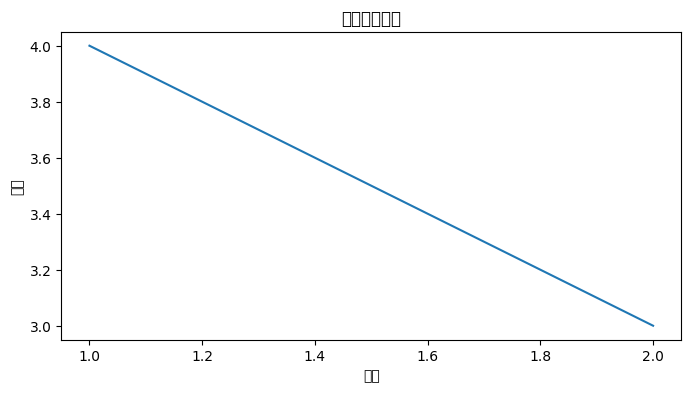

In [9]:
plt.figure(figsize=(8, 4))
plt.plot([1, 2], [4, 3])
plt.title('测试中文显示')
plt.xlabel('横轴')
plt.ylabel('纵轴')
plt.show()

In [2]:
df = pd.read_csv('performance_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,url,screenshotpath,run
0,109 ms,730 ms,1914 ms,0.232,0 ms,2084,2 KB,1027 ms,304,4681 ms,首页,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__market_overview_run1_22-0...,1
1,442 ms,581 ms,2102 ms,0.172,0 ms,1036,0 KB,1243 ms,362,3326 ms,模型,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__market_mw_asset_run1_22-0...,1
2,141 ms,1247 ms,2447 ms,0.321,1127 ms,5485,6 KB,1054 ms,378,6741 ms,应用,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__market_applet_run1_22-03-...,1
3,198 ms,544 ms,1590 ms,0.000,0 ms,760,0 KB,701 ms,276,1590 ms,知识,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__market_sample_knowledge_r...,1
4,109 ms,531 ms,1692 ms,0.000,0 ms,844,0 KB,700 ms,262,1720 ms,管理中心-用户,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__manage_center_users_run1_...,1


In [3]:
t_df = df.drop(['screenshotpath', 'run', 'url'], axis=1)
# t_df = df.columns.difference(['screenshotpath', 'url', 'run'])
t_df['host'] = df['url'].apply(lambda x: urlparse(x).netloc)
t_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,host
0,109 ms,730 ms,1914 ms,0.232,0 ms,2084,2 KB,1027 ms,304,4681 ms,首页,llmops.transwarp.io
1,442 ms,581 ms,2102 ms,0.172,0 ms,1036,0 KB,1243 ms,362,3326 ms,模型,llmops.transwarp.io
2,141 ms,1247 ms,2447 ms,0.321,1127 ms,5485,6 KB,1054 ms,378,6741 ms,应用,llmops.transwarp.io
3,198 ms,544 ms,1590 ms,0.000,0 ms,760,0 KB,701 ms,276,1590 ms,知识,llmops.transwarp.io
4,109 ms,531 ms,1692 ms,0.000,0 ms,844,0 KB,700 ms,262,1720 ms,管理中心-用户,llmops.transwarp.io


In [4]:
def clean_numeric(column):
    if column.dtype == 'object':
        return pd.to_numeric(column.str.replace(r'[^\d.]+', '', regex=True))
    else:
        return column

n_df = t_df.iloc[:, :10].apply(clean_numeric)
n_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive
0,109,730,1914,0.232,0,2084,2,1027,304,4681
1,442,581,2102,0.172,0,1036,0,1243,362,3326
2,141,1247,2447,0.321,1127,5485,6,1054,378,6741
3,198,544,1590,0.000,0,760,0,701,276,1590
4,109,531,1692,0.000,0,844,0,700,262,1720


### 归一化

In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
s_df = pd.DataFrame(
    scaler.fit_transform(n_df),
    columns=t_df.columns[0:10]
)
s_df['pagename'] = t_df['pagename']
s_df['host'] = t_df['host']
s_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
0,0.670717,0.797692,0.895920,0.339492,0.545455,0.628047,1.0,0.436602,0.591304,0.027108,main_page,llmops.transwarp.io
1,0.759417,0.992308,0.679629,0.956120,0.727273,0.499196,1.0,0.612742,0.917391,0.108434,model_management,llmops.transwarp.io
2,0.867558,1.000000,0.672342,0.743649,0.500000,0.688856,1.0,0.618364,1.000000,0.696386,app_management,llmops.transwarp.io
3,0.640340,0.837692,0.680472,0.247113,0.454545,0.484731,1.0,0.565896,0.739130,0.077711,corpus_text_dataset,llmops.transwarp.io
4,0.733900,0.887692,0.677865,0.184758,1.000000,0.563354,1.0,0.609619,0.760870,0.578916,knowledge_management,llmops.transwarp.io


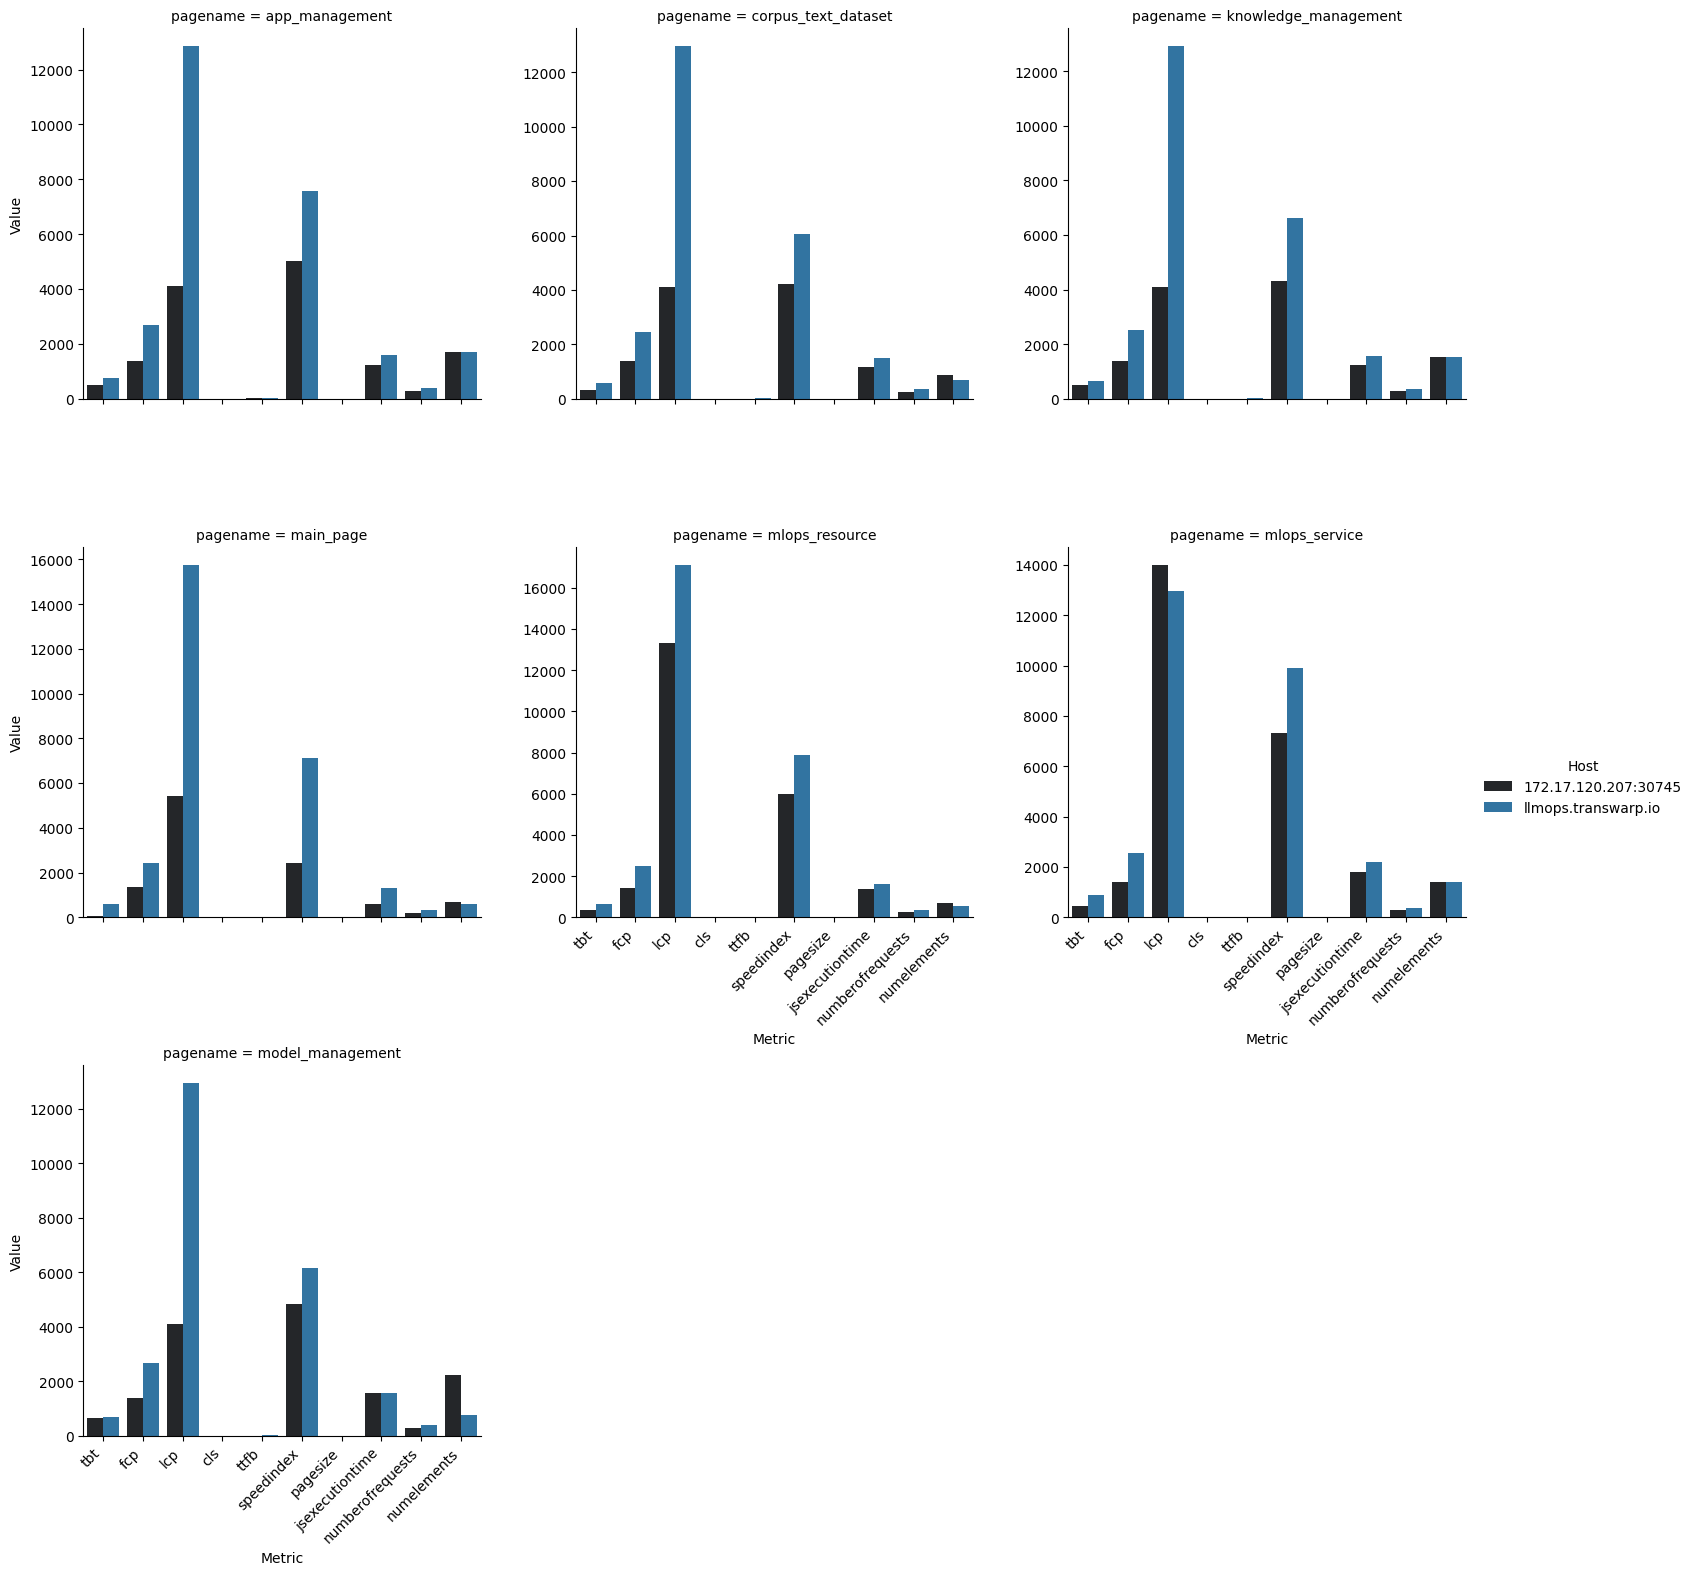

In [76]:
m_df = s_df.melt(id_vars=['pagename', 'host'], var_name='Metric', value_name='Value')
metric_order = m_df['Metric'].unique()
host_order = m_df['host'].unique()

g = sns.FacetGrid(m_df, col='pagename', col_wrap=3, sharey=False, height=5)
g.map(sns.barplot, 'Metric', 'Value', 'host', dodge=True, palette='dark:#1f77b4', order=metric_order, hue_order=host_order)

# 手动为每个子图设置 x 轴标签，只对最后三个有效, why?
for ax in g.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g.add_legend(title='Host')
plt.subplots_adjust(hspace=0.4)
plt.savefig('normalization.png', dpi=300, bbox_inches='tight')
plt.show()

### 百分比

In [71]:
s_df = pd.DataFrame(n_df, columns=t_df.columns[0:10])
s_df['pagename']= t_df['pagename']
s_df['host']= t_df['host']
s_df = s_df.sort_values(['pagename', 'host'])
s_df.head()


,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
9,503,1384,4102,0.255,14,5038,2,1237,296,1696,app_management,172.17.120.207:30745
2,771,2675,12853,0.322,20,7568,3,1596,406,1724,app_management,llmops.transwarp.io
10,312,1382,4096,0.000,9,4203,3,1177,267,875,corpus_text_dataset,172.17.120.207:30745
3,584,2464,12959,0.107,19,6044,3,1512,346,697,corpus_text_dataset,llmops.transwarp.io
11,493,1384,4087,0.000,11,4312,3,1223,272,1542,knowledge_management,172.17.120.207:30745


/tmp/ipykernel_3079/2057756127.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_df = s_df.groupby('pagename', group_keys=False).apply(lambda x: percentage_change(x.iloc[:, :10]))


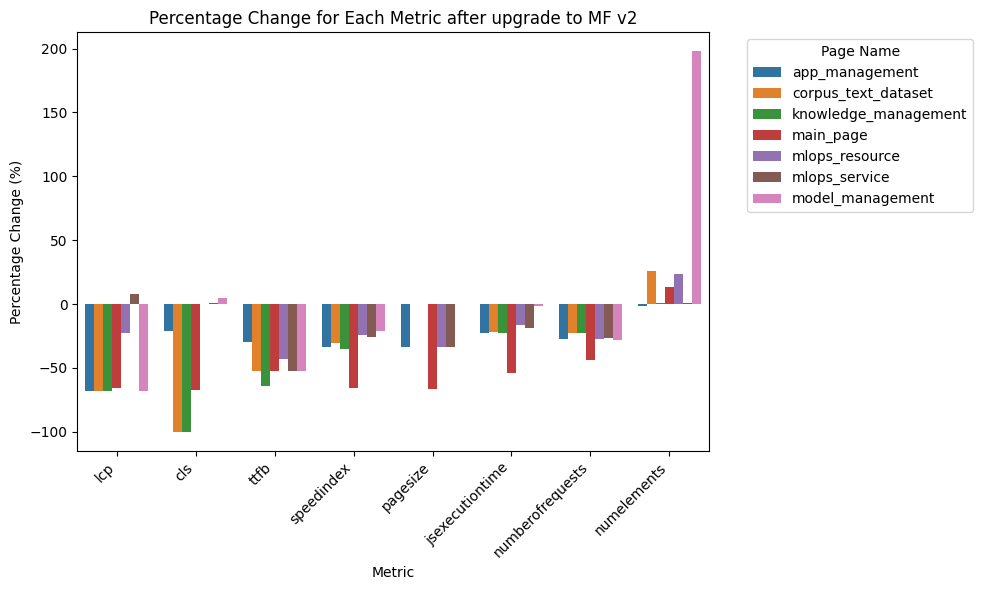

In [75]:
def percentage_change(df):
    row1, row2 = df.iloc[0], df.iloc[1]
    change = (row1 - row2) / row2.replace(0, 1) * 100
    return pd.Series(change, index=df.columns[2:])

g_df = s_df.groupby('pagename', group_keys=False).apply(lambda x: percentage_change(x.iloc[:, :10]))

m_df = g_df.reset_index().melt(id_vars='pagename', var_name='Metric', value_name='PercentageChange')
plt.figure(figsize=(10, 6))
sns.barplot(data=m_df, x='Metric', y='PercentageChange', hue='pagename')

plt.title('Percentage Change for Each Metric after upgrade to MF v2')
plt.ylabel('Percentage Change (%)')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')

plt.legend(title='Page Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('percentage_change_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 指标维度

In [7]:
s_df = pd.DataFrame(n_df, columns=t_df.columns[0:10])
s_df['pagename']= t_df['pagename']
s_df['host']= t_df['host']
s_df = s_df.sort_values(['pagename', 'host'])
s_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,host
13,538,1016,5688,0.116,19,3007,1,878,248,5921,应用,172.17.120.207:30745
2,141,1247,2447,0.321,1127,5485,6,1054,378,6741,应用,llmops.transwarp.io
18,879,952,2527,0.255,22,3867,1,1165,298,8093,应用管理,172.17.120.207:30745
7,447,530,1320,0.322,0,1348,0,1330,404,2148,应用管理,llmops.transwarp.io
12,857,1075,6650,0.025,15,2993,2,1291,250,8756,模型,172.17.120.207:30745


findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
/home/codespace/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from font(s) DejaVu Sans.
  self._figure.tight_layout(*args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  self._figure.tight_layout(*args, **kwargs)
findfont: Font family 'Source Han Sans TW' not found.
/home/codespace/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarni

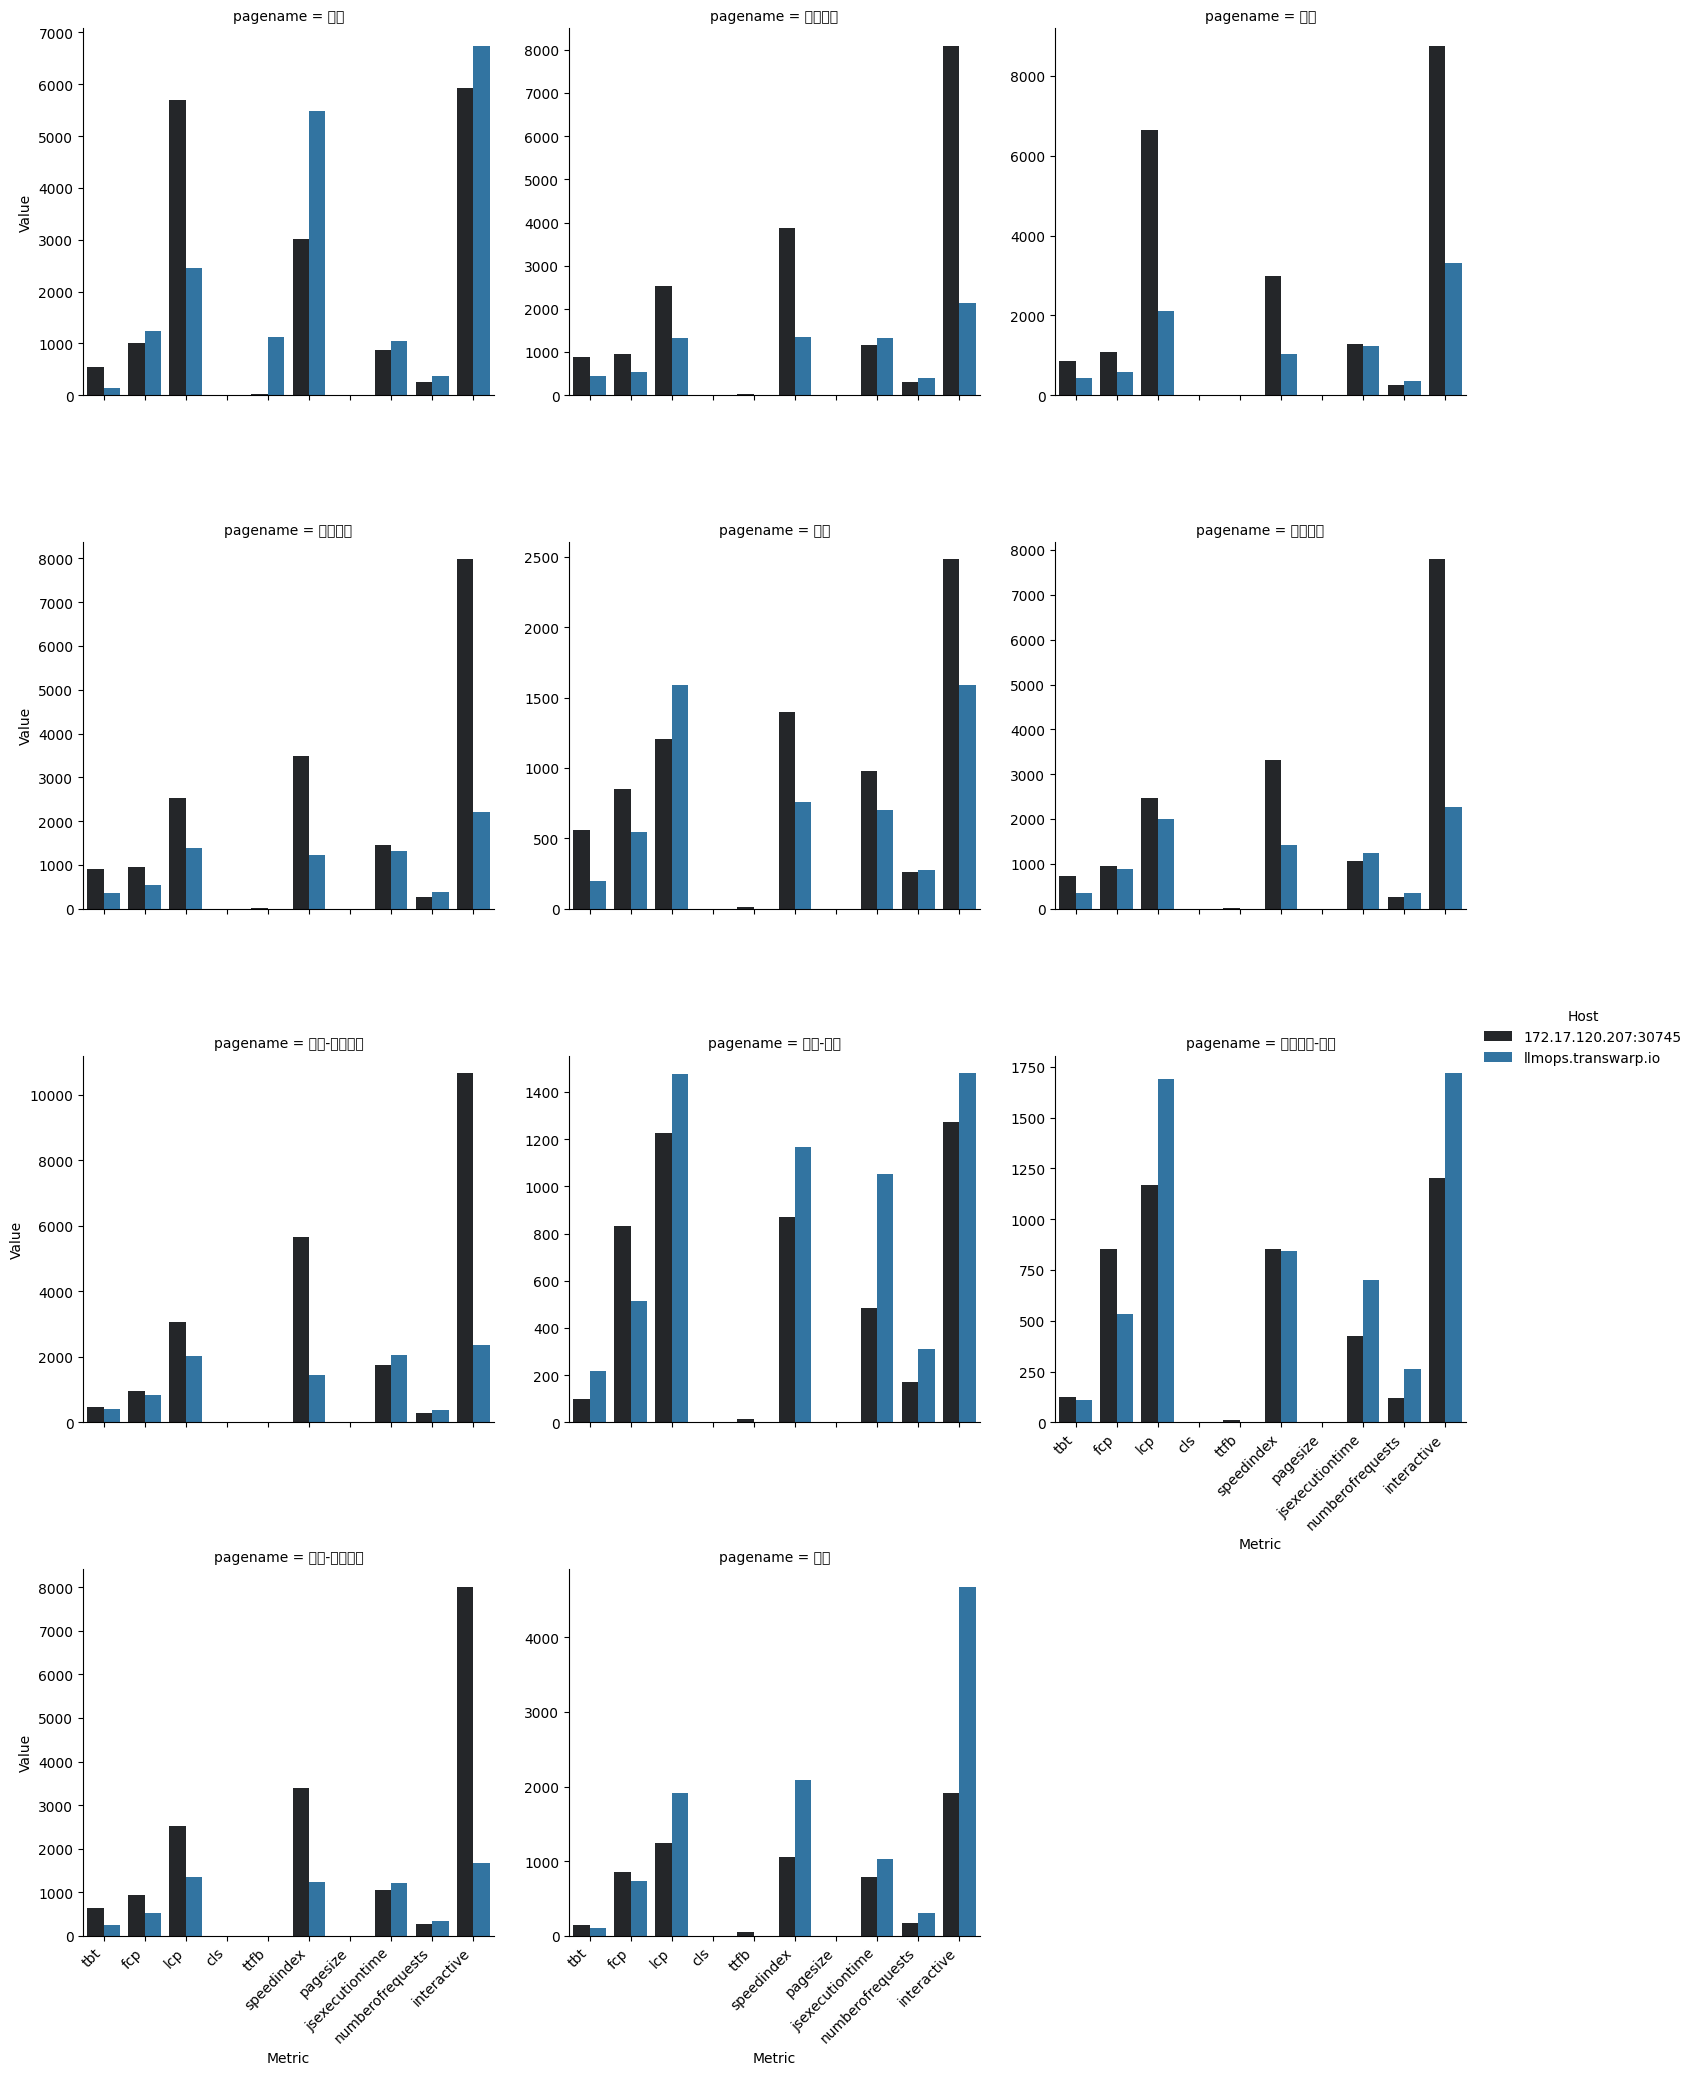

In [13]:
# I want to compare the same metrics on different pagename with different host, using grouped barplots, set bar color of `llmops.transwarp.io` with yellow, another with green
# Define colors for specific hosts

m_df = s_df.melt(id_vars=['pagename', 'host'], var_name='Metric', value_name='Value')

g = sns.FacetGrid(m_df, col='pagename', col_wrap=3, sharey=False, height=5)
g.map_dataframe(sns.barplot, x='Metric', y='Value', hue='host', dodge=True, order=m_df['Metric'].unique())

for ax in g.axes.flat:
  ax.set_xticks(range(len(m_df['Metric'].unique())))
  ax.set_xticklabels(m_df['Metric'].unique(), rotation=45, ha='right')

g.add_legend(title='Host')
plt.subplots_adjust(hspace=0.4)
plt.show()
# plt.savefig('grouped_barplots.png', dpi=300, bbox_inches='tight')